In [30]:
import gymnasium as gym
import ale_py  # Ensure Atari environments work
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import collections
import random
from gymnasium.wrappers import GrayscaleObservation, ResizeObservation
from collections import deque
import torch.nn.functional as F
import cv2

In [31]:
import numpy as np
from collections import deque
from gymnasium import spaces

class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.

        Returns lazy array, which is much more memory efficient.

        See Also
        --------
        baselines.common.atari_wrappers.LazyFrames
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = spaces.Box(low=0, high=255, shape=(shp[:-1] + (shp[-1] * k,)), dtype=env.observation_space.dtype)

    def reset(self):
        ob, info = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob(), info

    def step(self, action):
        ob, reward, done, truncated, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, truncated, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))

class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=env.observation_space.shape, dtype=np.float32)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0

class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers.

        This object should only be converted to numpy array before being passed to the model.

        You'd not believe how complex the previous solution was."""
        self._frames = frames
        self._out = None

    def _force(self):
        if self._out is None:
            self._out = np.stack(self._frames)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._force())

    def __getitem__(self, i):
        return self._force()[i]

    def count(self):
        frames = self._force()
        return frames.shape[frames.ndim - 1]

    def frame(self, i):
        return self._force()[..., i]


def wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=False, scale=False):
    """Configure environment for DeepMind-style Atari.
    """
    if episode_life:
        env = EpisodicLifeEnv(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    if scale:
        env = ScaledFloatFrame(env)
    if clip_rewards:
        env = ClipRewardEnv(env)
    if frame_stack:
        env = FrameStack(env, 4)
    return env

In [32]:
class DQN_CNN(nn.Module):
    def __init__(self, input_channels, action_dim):
        super(DQN_CNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=8, stride=4),  # Output: (32, 20, 20)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),  # Output: (64, 9, 9)
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),  # Output: (64, 7, 7)
            nn.ReLU()
        )


        self.fc_layers = nn.Sequential(
            nn.Linear(64*7*7, 512),  # Flattened CNN features
            nn.ReLU(),
            nn.Linear(512, action_dim)  # Output Q-values for each action
        )

    def forward(self, x):
        x = self.conv_layers(x)

        x = x.view(x.size(0), -1)  # Flatten

        x = self.fc_layers(x)
        return x

In [33]:
def select_action(env, model, state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()  # Random action (exploration)

    state = torch.FloatTensor(state).unsqueeze(0) / 255.0  # Normalize pixels
    state = state.to(device)
    with torch.no_grad():
        return model(state).argmax().item()

def train(model, target_model, buffer, optimizer, batch_size, gamma):
    if buffer.size() < batch_size:
        return

    # Sample batch from experience replay
    states, actions, rewards, next_states, dones = buffer.sample(batch_size)

    states = states.to(device)
    actions = actions.to(device)
    rewards = rewards.to(device)
    next_states = next_states.to(device)
    dones = dones.to(device)

    # Compute Q-values for current states
    q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)  # Select Q-values of taken actions

    # Compute next Q-values from the target network
    next_q_values = target_model(next_states).max(1)[0].detach()  # Max Q-value of next state

    dones = dones.to(torch.bool)
    # Zero next_q_values for terminal states
    next_q_values[dones] = 0.0

    # Compute target Q-values
    target_q_values = rewards + gamma * next_q_values

    # Compute loss using Huber loss (smooth_l1_loss)
    loss = F.smooth_l1_loss(q_values, target_q_values.detach())

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
    optimizer.step()


In [34]:
class ReplayBuffer:
    def __init__(self, capacity, demonstrations):
        self.buffer = collections.deque(maxlen=capacity)
        self.demonstrations = demonstrations

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((
            state,
            action,
            int(reward),
            next_state,
            bool(done)
        ))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size // 2)
        batch += random.sample(self.demonstrations, batch_size // 2)
        print(self.buffer[0][0].shape)
        print(self.demonstrations[0][0].shape)
        random.shuffle(batch)
        state, action, reward, next_state, done = zip(*batch)

        return (
            torch.FloatTensor(np.array(state)) / 255.0,  # Normalize pixels
            torch.LongTensor(action),
            torch.FloatTensor(reward),
            torch.FloatTensor(np.array(next_state)) / 255.0,
            torch.FloatTensor(done)
        )

    def size(self):
        return len(self.buffer)

In [35]:
import pickle

# load expert demonstrations
trace = []
for i in range(3):
    with open(f'traces/trace_{i}.pkl', 'rb') as f:
        trace += pickle.load(f)

def process_frame(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    frame = cv2.resize(
        frame, (84, 84), interpolation=cv2.INTER_AREA
    )
    return frame

demonstrations = []
for obj in trace:
    demonstrations.append((process_frame(obj['state']), obj['action'], obj['reward'], process_frame(obj['next_state']), obj['done']))

In [36]:
# Create the Atari environment

env = gym.make("ALE/Frogger-v5", render_mode="rgb_array")  # Create Atari env

env = GrayscaleObservation(env, keep_dim=False)
env = ResizeObservation(env, (84, 84))

env = wrap_deepmind(env, episode_life=False, clip_rewards=False, frame_stack=True, scale=False)

# Check Action / State space
obs, info = env.reset()

action_dim = env.action_space.n
print(f"Observation space: {env.observation_space}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dqn = DQN_CNN(4, action_dim).to(device)
target_dqn = DQN_CNN(4, action_dim).to(device)
target_dqn.load_state_dict(dqn.state_dict())

optimizer = optim.Adam(dqn.parameters(), lr=0.0001)
replay_buffer = ReplayBuffer(5000, demonstrations)

num_episodes = 5000
batch_size = 32
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.9995
target_update_freq = 100
rewards_list = []

for episode in range(num_episodes):
    state, info = env.reset()
    # skip first 100 frames as no_op_frames
    for i in range(100):
      next_state, reward, done, truncated, info = env.step(0)

    state = np.array(next_state).squeeze()
    total_reward = 0
    done = False

    while not done:
        action = select_action(env, dqn, state, epsilon)
        next_state, reward, done, truncated, info = env.step(action)
        next_state = np.array(next_state).squeeze()

        replay_buffer.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        train(dqn, target_dqn, replay_buffer, optimizer, batch_size, gamma)

    rewards_list.append(total_reward)

    if episode % target_update_freq == 0:
        target_dqn.load_state_dict(dqn.state_dict())
        torch.save(dqn.state_dict(), f"frogger_dqfd_model_{episode}.pth")

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    print(f"Episode {episode}, Reward: {total_reward}, Epsilon: {epsilon:.3f}")

plt.plot(rewards_list)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Training Performance on Frogger")
plt.show()

# store the model
torch.save(dqn.state_dict(), "frogger_dqfd_model.pth")
# save the rewards_list in a txt file with comma separated
np.savetxt("frogger_dqn_rewards.txt", rewards_list, delimiter=",")

Observation space: Box(0, 255, (84, 336), uint8)
(4, 84, 84)
(84, 84)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (32,) + inhomogeneous part.

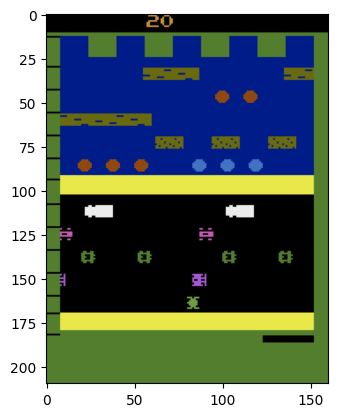

Total Steps: 290


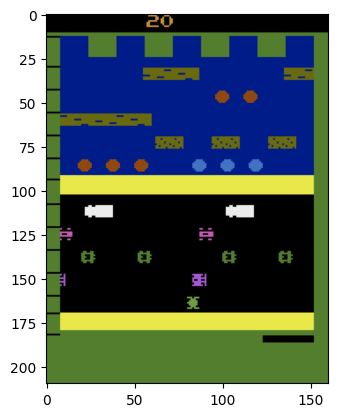

In [ ]:
# draw dqn playing game
state, info = env.reset()
state = np.array(state).squeeze()
done = False
step = 0
while not done:
    step += 1
    action = select_action(env, dqn, state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    state = next_state

    if done:
        break

    img = env.render()
    # store frame as pngs
    plt.imsave(f"./dqfd/frame_{step}.png", img)
    plt.imshow(img)
    clear_output(wait=True)
    display(plt.gcf())
print(f"Total Steps: {step}")
env.close()

In [ ]:
import os
os.system("ffmpeg -i dqfd/frame_%01d.png -vcodec mpeg4 -y movie.mp4")


0